## **California**

In [59]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import    RandomForestRegressor
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from geopy.distance import geodesic
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gc
import warnings
warnings.filterwarnings('ignore')

In [2]:
url='housing.csv'
df=pd.read_csv(url,sep=',')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
print('Número de filas :',df.shape[0])
print('Número de columnas :',df.shape[1])

Número de filas : 20640
Número de columnas : 10


In [4]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

<Axes: >

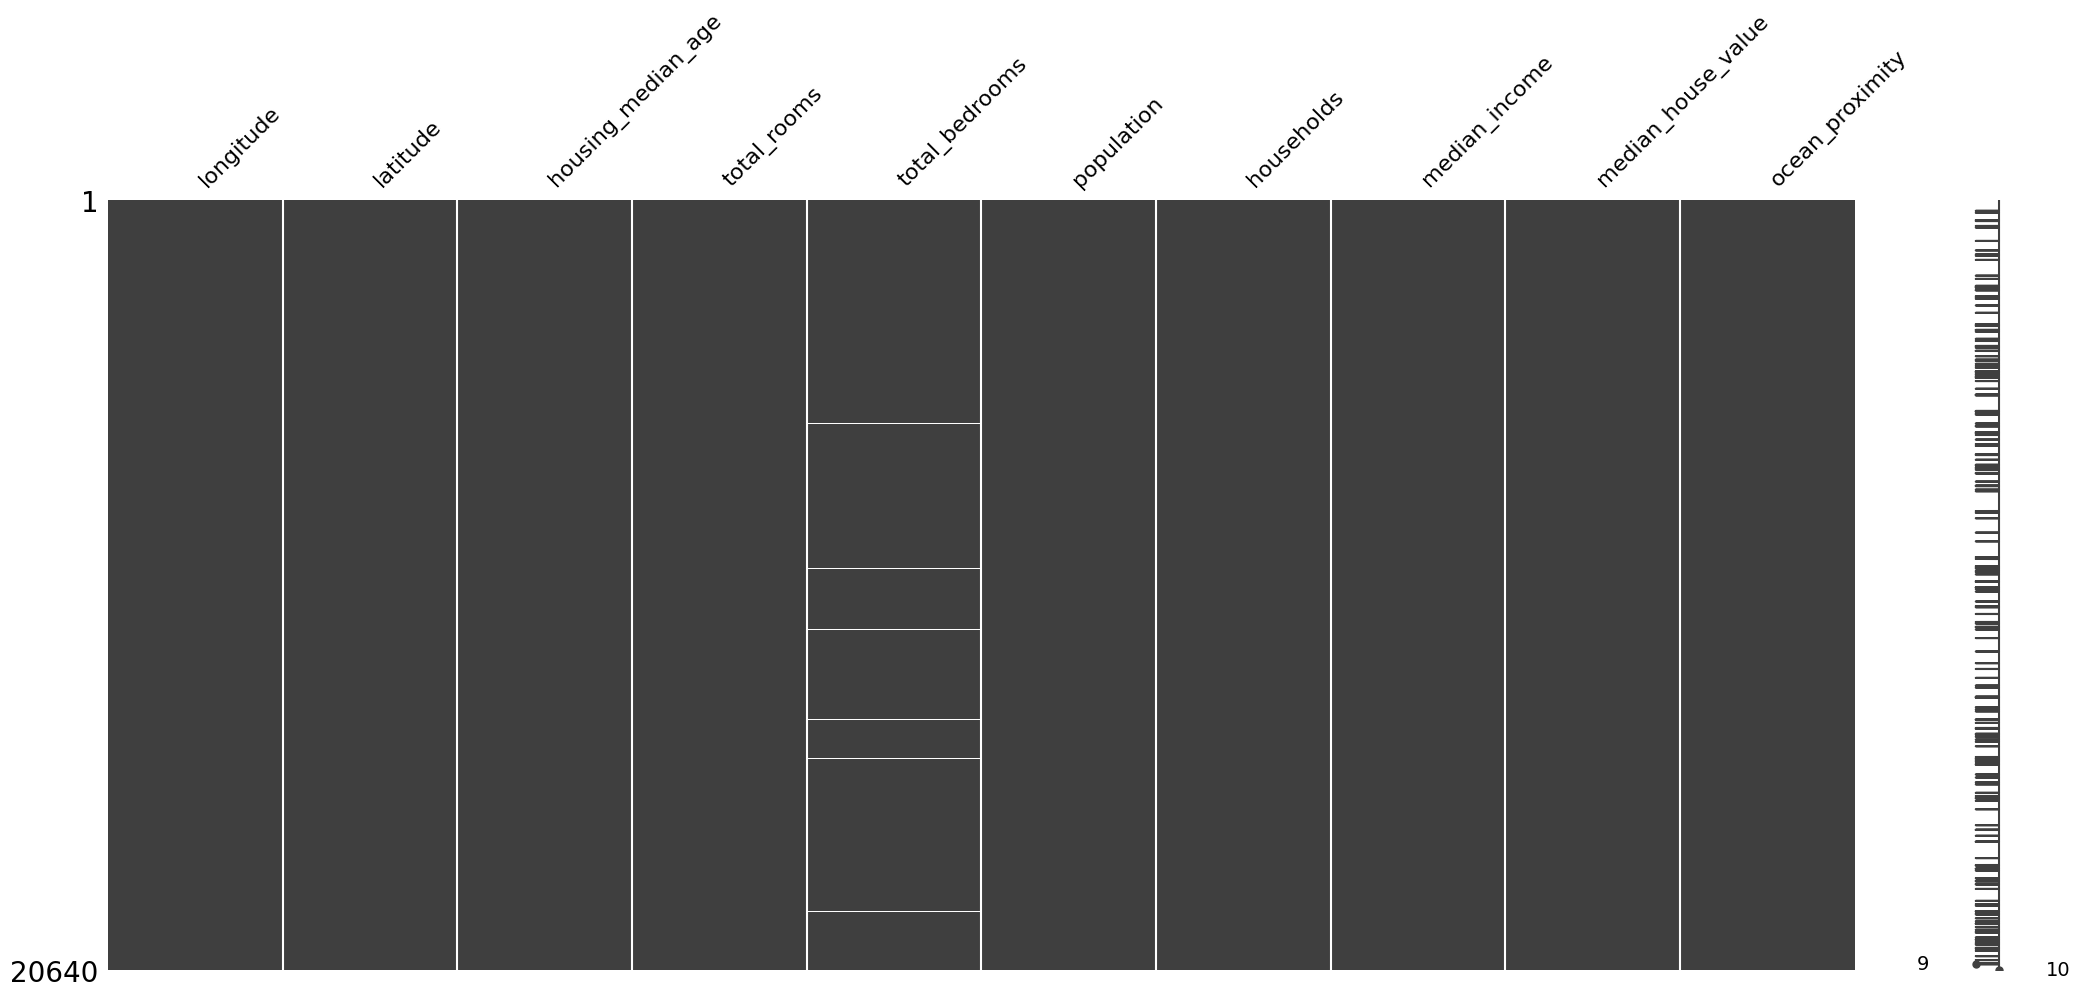

In [5]:
msno.matrix(df)

<Axes: >

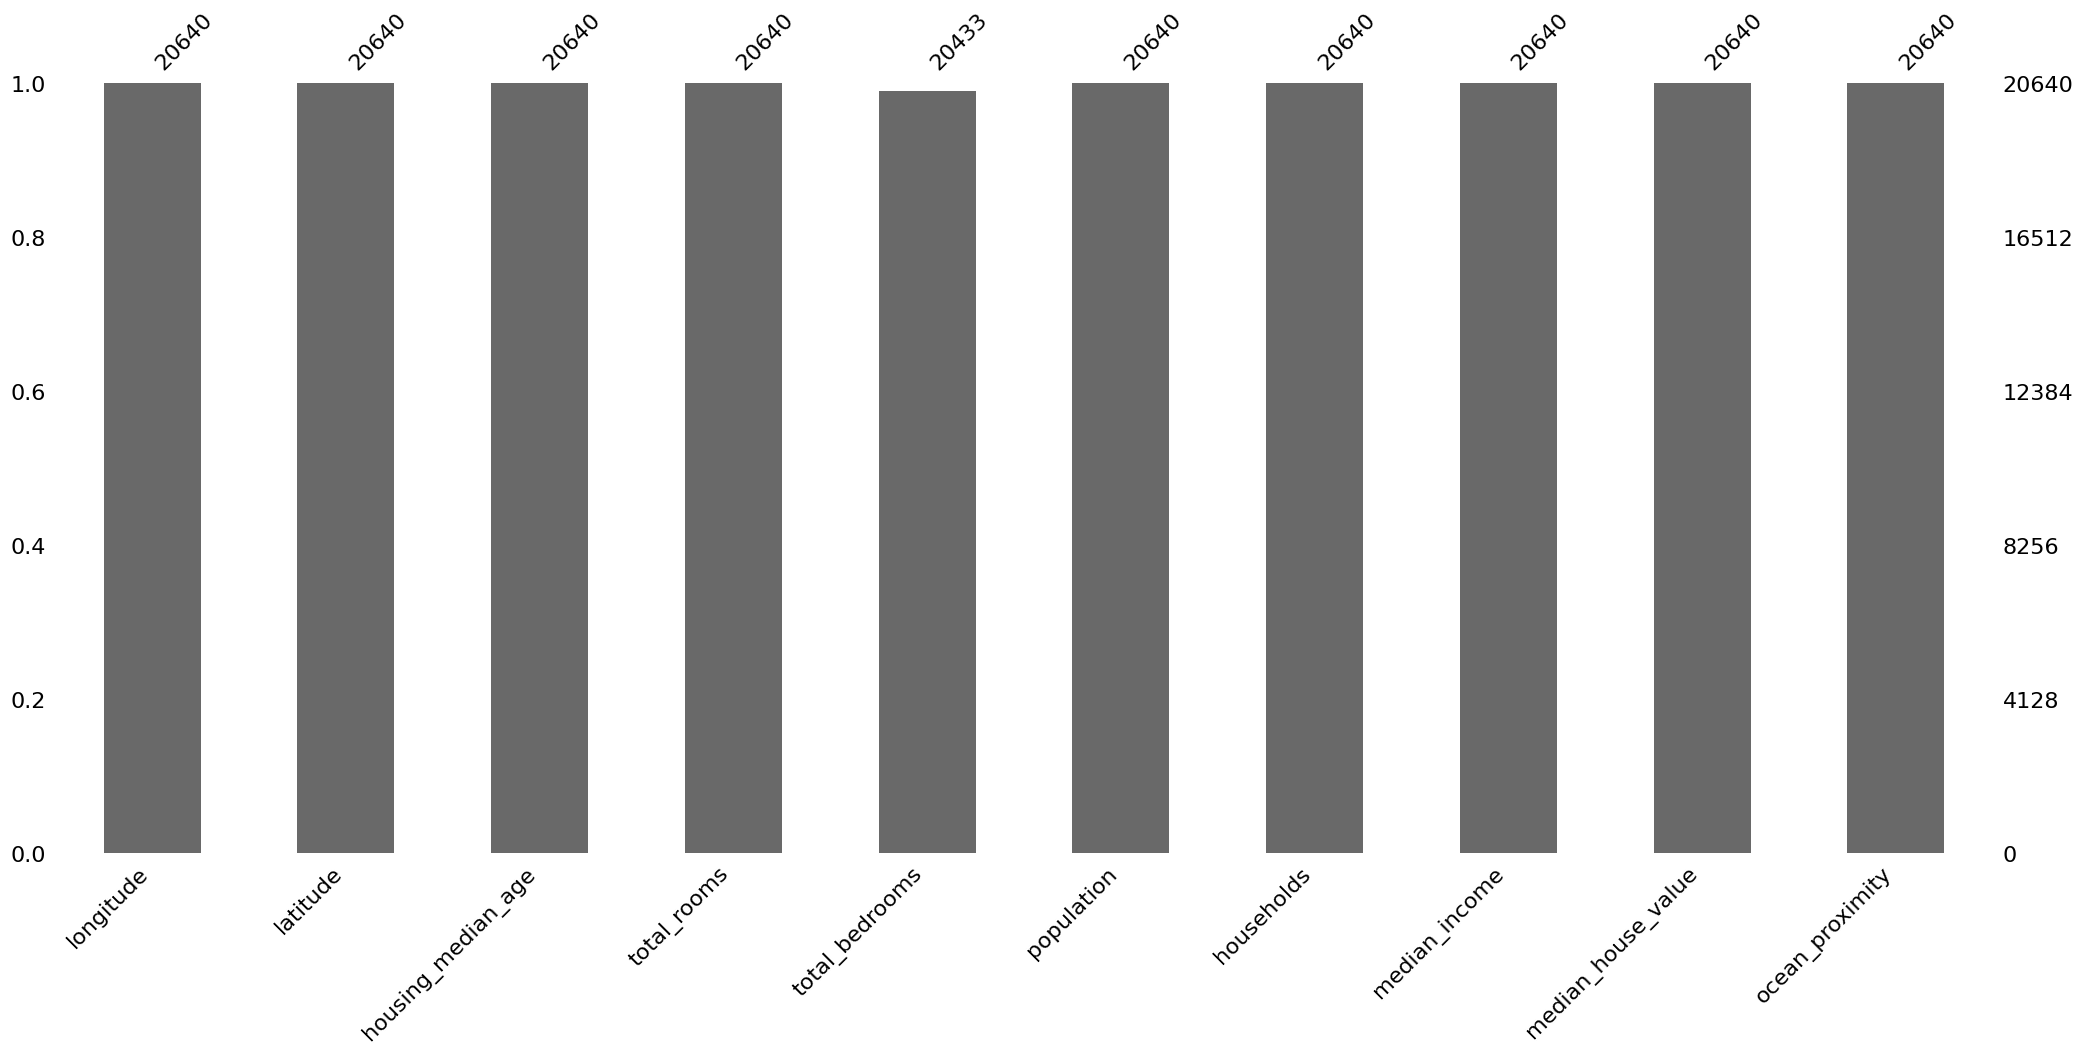

In [6]:
msno.bar(df)

In [7]:
df[df.isnull().any(axis=1)] 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


## **EDA**

In [8]:
df.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')

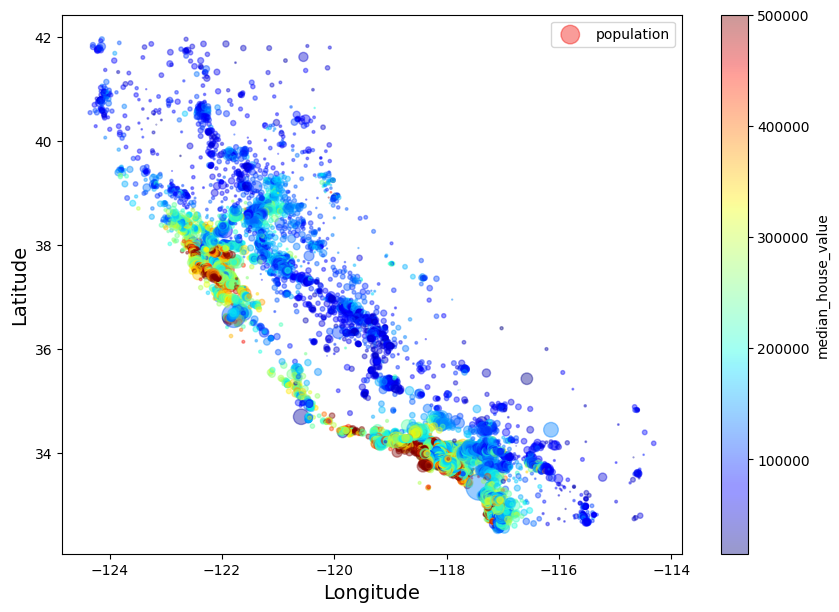

In [9]:
df.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=df['population']/100, label='population', figsize=(10,7),
				c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend() 
plt.show()

In [11]:
def snsPairGrid(df):

    ''' Plots a Seaborn Pairgrid w/ KDE & scatter plot of df features'''
    g = sns.PairGrid(df,diag_sharey=False)
    g.fig.set_size_inches(14,13)
    g.map_diag(sns.kdeplot, lw=2) # draw kde approximation on the diagonal
    g.map_lower(sns.scatterplot,s=15,edgecolor="k",linewidth=1,alpha=0.4) # scattered plot on lower half
    g.map_lower(sns.kdeplot,cmap='plasma',n_levels=10) # kde approximation on lower half
    plt.tight_layout()
    
snsPairGrid(df[['median_income','total_rooms','housing_median_age','latitude','median_house_value','population']])

In [19]:
num=df.select_dtypes(include='number').columns

In [22]:
df[num].corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069608,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066983,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.320451,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.930380,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,0.049686
population,0.099773,-0.108785,-0.296244,0.857126,0.877747,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.979728,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007723,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049686,-0.024650,0.065843,0.688075,1.000000


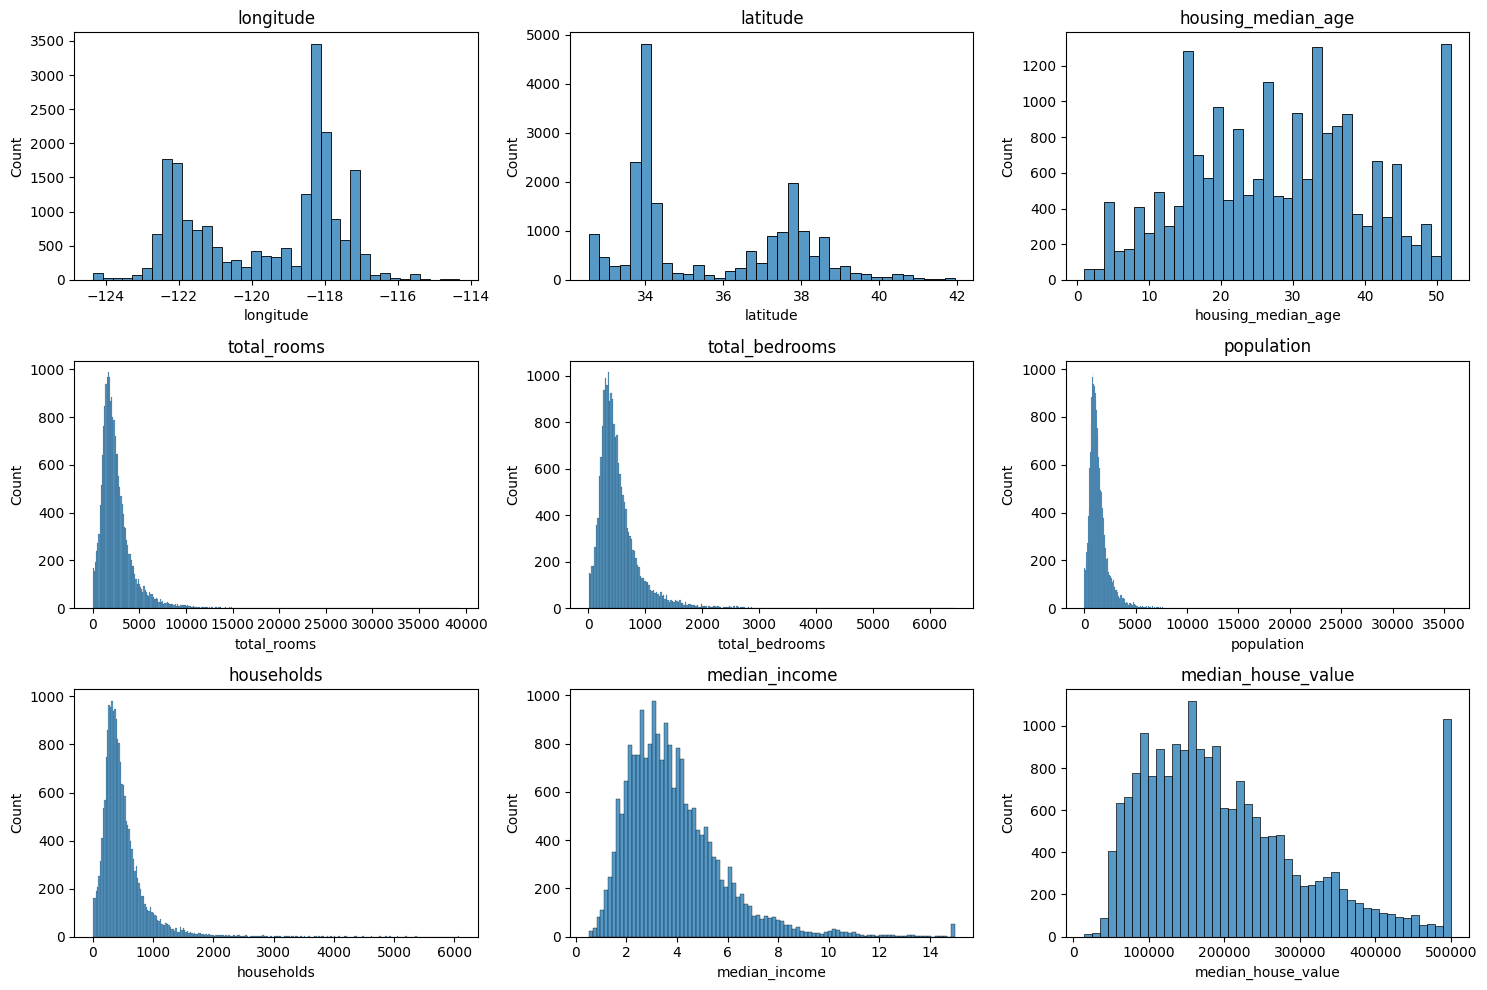

In [26]:
# Crear la figura y los ejes para 3 filas y 3 columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Ajusta el tamaño según tu necesidad
axes = axes.flatten()  # Para poder acceder a los ejes de forma lineal

# Graficar cada histograma en la cuadrícula
for i, column in enumerate(num):
    sns.histplot(data=df, x=column, ax=axes[i])  # Asignar cada gráfico a un subplot
    axes[i].set_title(column)  # Título para cada gráfico

# Ajustar el espaciado entre gráficos
plt.tight_layout()
plt.show()

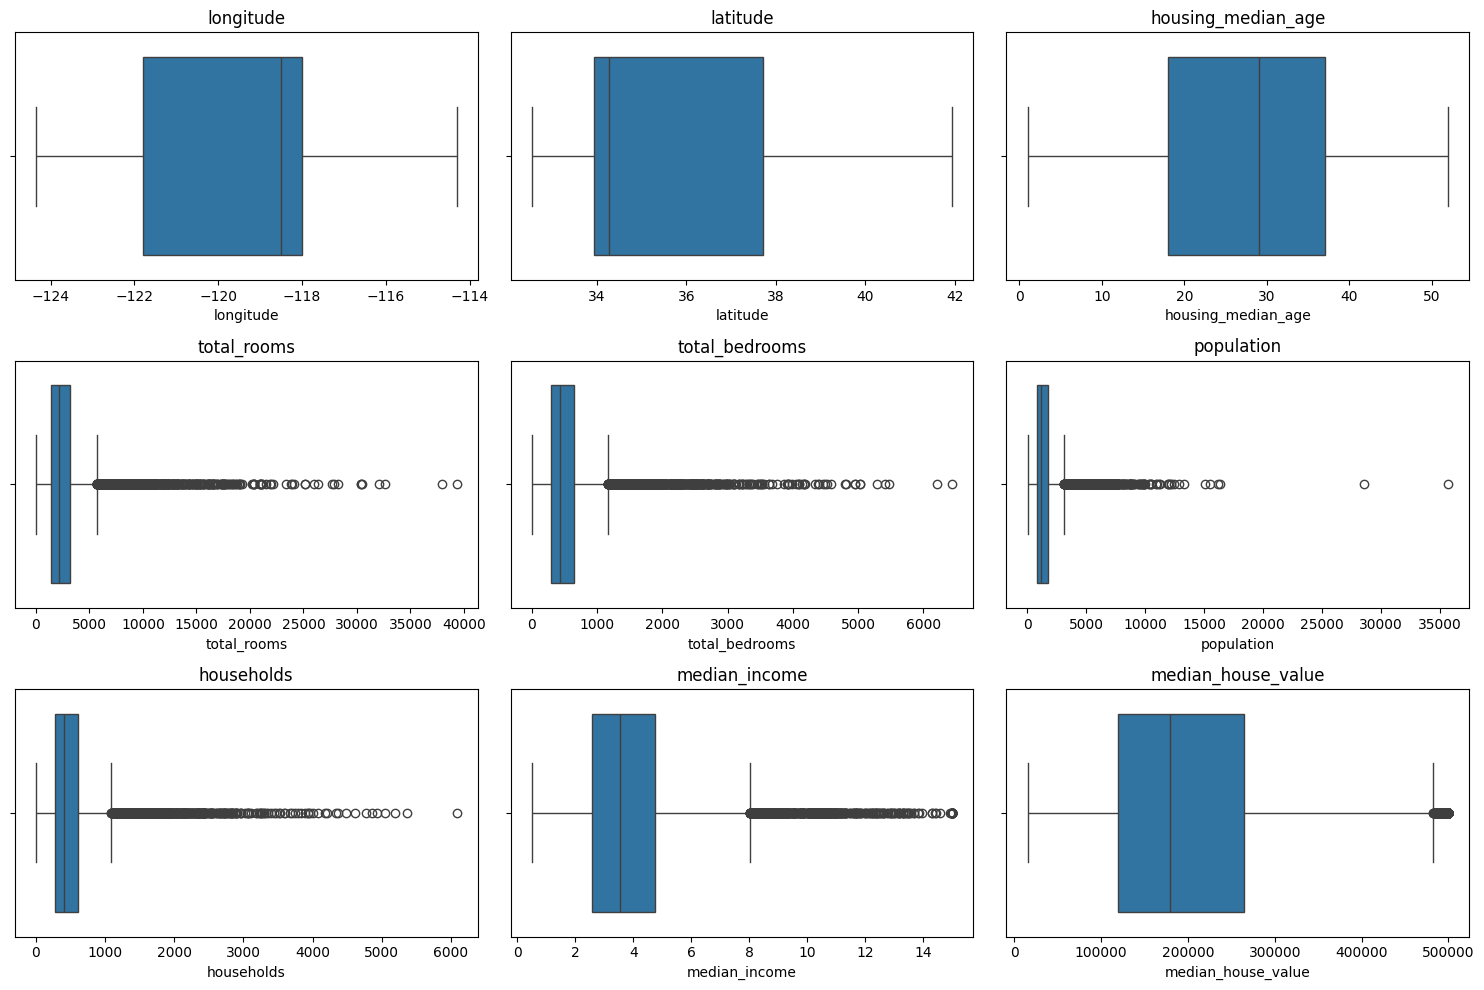

In [31]:
# Crear la figura y los ejes para 3 filas y 3 columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))  # Ajusta el tamaño según tu necesidad
axes = axes.flatten()  # Para poder acceder a los ejes de forma lineal

# Graficar cada histograma en la cuadrícula
for i, column in enumerate(num):
    sns.boxplot(data=df, x=column, ax=axes[i])  # Asignar cada gráfico a un subplot
    axes[i].set_title(column)  # Título para cada gráfico

# Ajustar el espaciado entre gráficos
plt.tight_layout()
plt.show()

In [27]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Crear un subplot de 3 filas y 3 columnas
fig = make_subplots(rows=3, cols=3, subplot_titles=num)

# Graficar cada histograma en su respectivo subplot
for i, column in enumerate(num):
    # Crear histograma con plotly express
    fig_hist = px.histogram(df, x=column)
    
    # Añadir la traza al subplot correspondiente
    row = (i // 3) + 1  # Calcular fila (división entera)
    col = (i % 3) + 1   # Calcular columna (resto de la división)
    for trace in fig_hist['data']:  # Extraer las trazas de la figura
        fig.add_trace(trace, row=row, col=col)

# Actualizar el layout para el tamaño de la figura y el título
fig.update_layout(height=800, width=800, showlegend=False, title_text="Histograms in 3x3 Grid")

# Mostrar el gráfico
fig.show()


In [30]:
df[num].describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [35]:
df.dropna(subset=['total_bedrooms'], inplace=True) # eliminar las columnas vacias de la columna total bedrooms

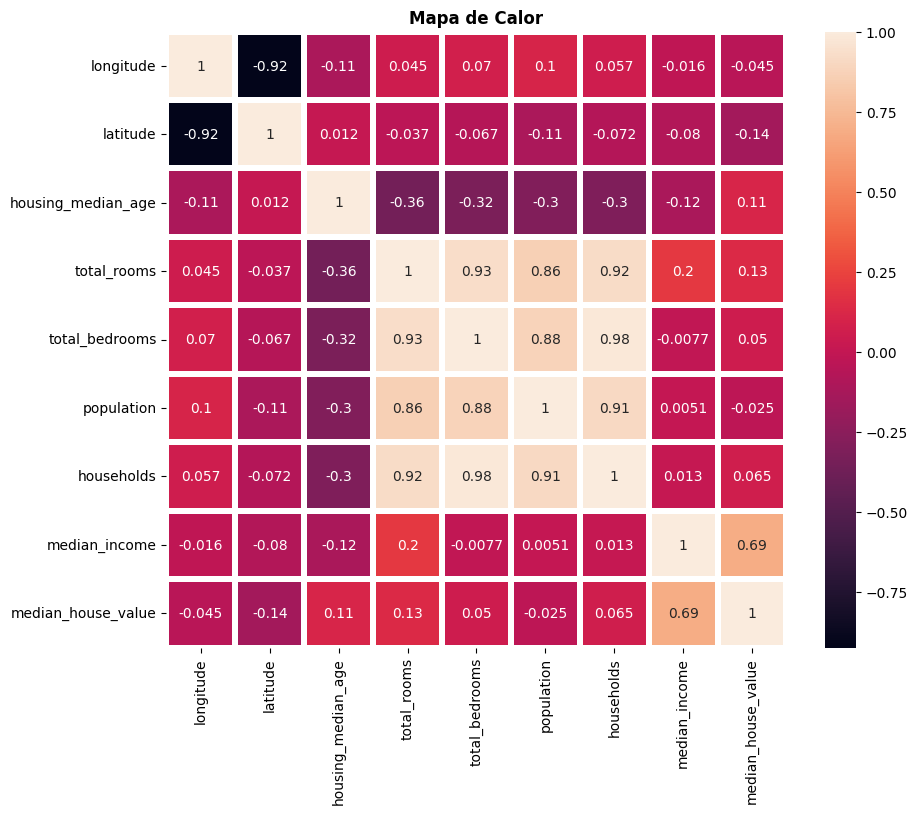

In [39]:
plt.figure(figsize=(10,8))
sns.heatmap(df[num].corr(),annot=True,fmt='.2g',linewidths=3)
plt.title('Mapa de Calor',fontsize=12,weight='bold')
plt.show()

In [45]:
df_ocean=df.groupby('ocean_proximity',as_index=False)[['median_house_value','median_income']].sum()
df_ocean=pd.DataFrame(df_ocean)
df_ocean

,ocean_proximity,median_house_value,median_income
0,<1H OCEAN,2.170581e+09,38223.7621
1,INLAND,8.113300e+08,20854.4902
2,ISLAND,1.902200e+06,13.7221
3,NEAR BAY,5.885640e+08,9478.7185
4,NEAR OCEAN,6.544833e+08,10528.7521


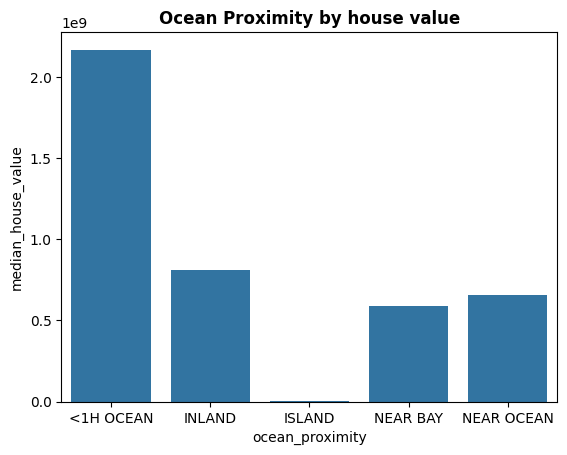

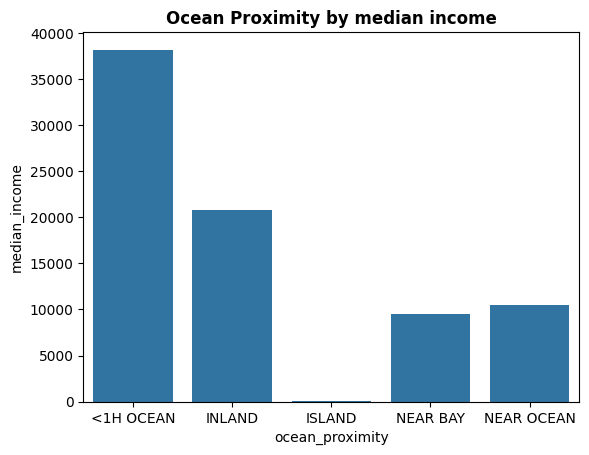

In [48]:
sns.barplot(data=df_ocean,x='ocean_proximity',y='median_house_value')
plt.title('Ocean Proximity by house value',fontsize=12,weight='bold')
plt.show()

sns.barplot(data=df_ocean,x='ocean_proximity',y='median_income')
plt.title('Ocean Proximity by median income',fontsize=12,weight='bold')
plt.show()

In [51]:
le=LabelEncoder()
df['ocean_proximity_encoded']=le.fit_transform(df['ocean_proximity'])
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_encoded
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


In [53]:
df.drop(columns=['ocean_proximity'],inplace=True)

In [69]:
cols1=['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value']

In [70]:
scaler=StandardScaler()
df_scaled=scaler.fit_transform(df[cols1])
df_scaled=pd.DataFrame(df_scaled, columns=cols1)
df_scaled['ocean_proximity_encoded']=df['ocean_proximity_encoded']
df_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_encoded
0,-1.327314,1.051717,0.982163,-0.803813,-0.970325,-0.973320,-0.976833,2.345163,2.128819,3.0
1,-1.322323,1.042355,-0.606210,2.042130,1.348276,0.861339,1.670373,2.332632,1.313626,3.0
2,-1.332305,1.037674,1.855769,-0.535189,-0.825561,-0.819769,-0.843427,1.782939,1.258183,3.0
3,-1.337296,1.037674,1.855769,-0.623510,-0.718768,-0.765056,-0.733562,0.932970,1.164622,3.0
4,-1.337296,1.037674,1.855769,-0.461970,-0.611974,-0.758879,-0.628930,-0.013143,1.172418,3.0


## **Split Data Target & Features**

In [71]:
X=df_scaled.drop('median_house_value',axis=1)
y=df_scaled['median_house_value']

## **Split Train & Test data**

In [80]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=100,shuffle=True)

In [81]:
rf=RandomForestRegressor()
columns=['RandomForestRegressor']
train_score=[]
rec_score=[]
mae_val=[]
mse_val=[]

def all(model):
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    accuracy_train=model.score(x_train,y_train)*100
    recall_result=r2_score(y_pred,y_test)*100
    mse=mean_squared_error(y_test,y_pred)
    mae=mean_absolute_error(y_test,y_pred)
    train_score.append(accuracy_train)
    rec_score.append(recall_result)
    mse_val.append(mse)
    mae_val.append(mae)
    print('Accuracy after train the model is :',accuracy_train)
    print('Result recall score is :',recall_result)
    
    print('Mean Squared Error :' , mse.round(2)*100)
    print('Mean Absolute Error :',mae.round(2)*100)

In [82]:
all(rf)

Accuracy after train the model is : 97.32996611699029
Result recall score is : 74.99312351635885
Mean Squared Error : 19.0
Mean Absolute Error : 28.000000000000004
